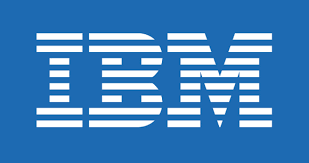

In [72]:
# from IPython.display import Image
Image("C:/Users/h.louhichi/Documents/Coursera_Capstone/IBM.png")

# IBM: The battle of Neighborhoods 

## Opening a Restaurant in Bologna, Italy

<h1 id="tocheading">Reporting</h1>
<div id="toc"></div>

In [81]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [82]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### IMPORT ALL THE LIBRARIES NEEDED

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
# how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k video
from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries imported.')

Libraries imported.


### GET NEEDED COORDINATES(Bologna-Italy)

In [5]:
# get coordinates of Bologna
bologna_address = 'Bologna, Italy'

geolocator = Nominatim(user_agent="bologna_explorer")
location = geolocator.geocode(bologna_address)
latitude = location.latitude
longitude = location.longitude
bucharest_center = [latitude, longitude ]
print('The geograpical coordinates of {} are {}, {}.'.format(bologna_address, latitude, longitude))

The geograpical coordinates of Bologna, Italy are 44.4937577, 11.3430308.


In [6]:
url = "https://it.wikipedia.org/wiki/Quartieri_di_Bologna"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

    
df_neighborhood = pd.read_html(url)[0]
df_neighborhood.rename(columns={'Abitantial 31/12/2019[2]':'Population', 'Quartiere':'Neighborhoods','Densità (ab/km²)':'Density'}, 
                       inplace = True)

df_neighborhood = df_neighborhood[['Neighborhoods','Population']]
print("There are {} neighborhoods in {}".format(df_neighborhood.shape[0], bologna_address))

There are 6 neighborhoods in Bologna, Italy


In [8]:
df_neighborhood

,Neighborhoods,Population
0,QuartiereBorgo Panigale-Reno,61.359
1,QuartiereSan Donato-San Vitale,66.320
2,Quartiere Navile,69.525
3,Quartiere Porto-Saragozza,69.595
4,Quartiere Santo Stefano,64.510
5,Quartiere Savena,60.142


### GET NEIGHBORHOODS COORDINATES(Bologna-Italy)

In [9]:
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,bologna_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Neighborhoods"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of neighborhoods are as below")
df_neighborhood.head()

Geographical coordinates of neighborhoods are as below


,Neighborhoods,Population,Latitude,Longitude
0,QuartiereBorgo Panigale-Reno,61.359,44.518288,11.282093
1,QuartiereSan Donato-San Vitale,66.320,44.498663,11.357947
2,Quartiere Navile,69.525,44.518789,11.333586
3,Quartiere Porto-Saragozza,69.595,44.490892,11.329974
4,Quartiere Santo Stefano,64.510,44.597542,11.361034


In [10]:

#create map of Bologna using latitude and longitude values
map_bologna= folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bologna)  
    
map_bologna

In [80]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

CLIENT_ID = 'GHYTM31GT1NZ4G0DCR240VNPF2RORKEWX45JA42HOCQDE0KQ'
CLIENT_SECRET = 'UFK2RZJI2R5UCYIFQOLCUGKWMFTE3IZXKHLN3XKPKIAB2J0X'
VERSION = '29012021'


### LET'S START THE ANALYSIS AND SEARCH FOR THE VENUES 

In [12]:
LIMIT = 400

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=2000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhoods'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 108 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Bar Tiffany,4c7e3eafd598a0933217c562,44.517135,11.276211,484,Café
1,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Ducati Motor Factory & Museum,4c001196daf9c9b6c636fbef,44.516274,11.268851,1074,Factory
2,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Ai Pini,4bf03fd9c601a593bf78c3d1,44.513514,11.286690,644,Italian Restaurant
3,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Tato e Vino,4c9bba479975a143ead52bcf,44.510076,11.287593,1013,Italian Restaurant
4,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Teatri di Vita,4d39e5246de7721e5226e949,44.514702,11.287630,593,Theater


In [13]:

print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Italian Restaurant,44
Café,22
Hotel,19
Ice Cream Shop,13
Pizza Place,13
Plaza,12
Dessert Shop,8
Park,6
Restaurant,6


In [14]:
venues = neighborhood_venues['VenueCategory'].unique()
#print('All venues : {}'.format(venues))
print('All Restaurants : {}'.format([i for i in venues if ('estaurant' in i) |('izza' in i) |('rattoria' in i) ]))

All Restaurants : ['Italian Restaurant', 'Restaurant', 'Pizza Place', 'Chinese Restaurant', 'Fast Food Restaurant', 'Greek Restaurant', 'Mediterranean Restaurant', 'Trattoria/Osteria', 'Indian Restaurant', 'Emilia Restaurant', 'Persian Restaurant', 'Seafood Restaurant', 'Japanese Restaurant', 'Vegetarian / Vegan Restaurant', 'African Restaurant', 'Campanian Restaurant', 'German Restaurant', 'Asian Restaurant', 'Gluten-free Restaurant', 'Falafel Restaurant', 'Venezuelan Restaurant', 'Argentinian Restaurant']


In [15]:
neighborhood_venues[neighborhood_venues['VenueName'].str.lower().str.contains('')]

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Bar Tiffany,4c7e3eafd598a0933217c562,44.517135,11.276211,484,Café
1,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Ducati Motor Factory & Museum,4c001196daf9c9b6c636fbef,44.516274,11.268851,1074,Factory
2,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Ai Pini,4bf03fd9c601a593bf78c3d1,44.513514,11.286690,644,Italian Restaurant
3,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Tato e Vino,4c9bba479975a143ead52bcf,44.510076,11.287593,1013,Italian Restaurant
4,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Teatri di Vita,4d39e5246de7721e5226e949,44.514702,11.287630,593,Theater
5,QuartiereBorgo Panigale-Reno,44.518288,11.282093,"Mast - Manifattura di Arti, Sperimentazioni e ...",524f09b411d255e4859112b1,44.505091,11.296411,1857,Museum
6,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Antica Trattoria Del Pontelungo,4c5bfc9d7735c9b65df08a72,44.509240,11.295030,1438,Italian Restaurant
7,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Villa Aretusi,4cfa27317f2db1f768b325d4,44.507350,11.284624,1234,Italian Restaurant
8,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Harley Davidson Bologna,4d09e1508ea0a1432ce9e273,44.530880,11.267231,1831,Motorcycle Shop
9,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Trattoria della Salute,4e8306054690ac9d4a1327a2,44.524890,11.274950,928,Restaurant


### RESTAURANTS COMPARED TO THE TOTAL NUMBER OF COMMERCIAL ACTIVITIES

In [52]:

restaurants =[i for i in venues if ('estaurant' in i) |('izza' in i) |('rattoria' in i) ]


# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurants:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
restaurants_df = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(restaurants) ]

print('Total number of restaurants:', len(restaurants_df['VenueId'].unique()))

print('Percentage of restaurants: {:.2f}%'.format(len(restaurants_df['VenueId'].unique()) / 
                                                          len(neighborhood_venues['VenueId'].unique()) * 100))

Total number of restaurants: 106
Percentage of restaurants: 32.52%


In [20]:
neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

,RestaurantCount
Neighborhood,
Quartiere Navile,39
Quartiere Porto-Saragozza,29
Quartiere Santo Stefano,7
Quartiere Savena,1
QuartiereBorgo Panigale-Reno,15
QuartiereSan Donato-San Vitale,25


In [22]:
neighborhood_venues.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "Commercial_activities"})[['Commercial_activities']]

,Commercial_activities
Neighborhood,
Quartiere Navile,100
Quartiere Porto-Saragozza,100
Quartiere Santo Stefano,19
Quartiere Savena,3
QuartiereBorgo Panigale-Reno,56
QuartiereSan Donato-San Vitale,100


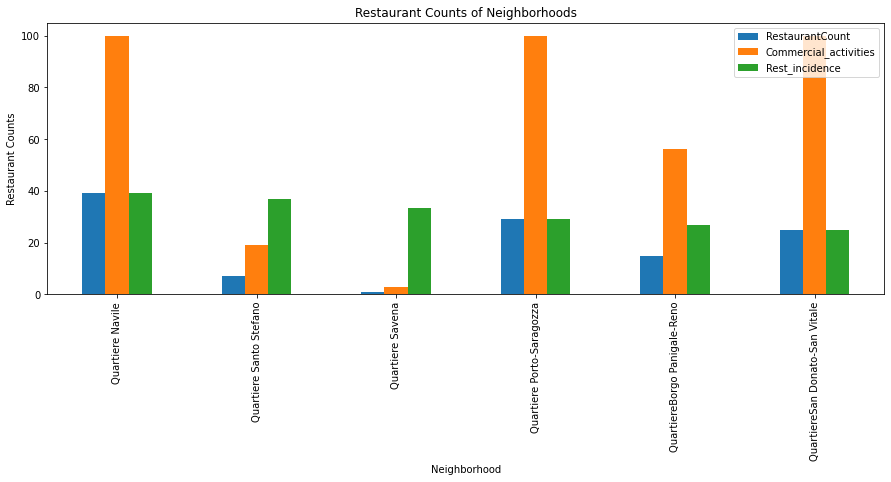

In [32]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']].reset_index()

# get counts of all commercial activities in each Neighborhood(incl. Restaurants)
df_comm_counts = neighborhood_venues.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "Commercial_activities"})[['Commercial_activities']].reset_index()

df_rest_counts= df_rest_counts.merge(df_comm_counts).set_index('Neighborhood')
df_rest_counts['Rest_incidence'] =df_rest_counts['RestaurantCount']/df_rest_counts['Commercial_activities']*100
df_rest_counts= df_rest_counts.sort_values(by=['Rest_incidence'],ascending =False)
######
#Draw graph
df_rest_counts[['RestaurantCount','Commercial_activities','Rest_incidence']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

### WE INCLUDE ALSO THE RAITINGS OF RESTAURANTS

In [33]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,4bf03fd9c601a593bf78c3d1,7.8,35.0
1,4c9bba479975a143ead52bcf,7.8,31.0
2,4c5bfc9d7735c9b65df08a72,7.8,19.0
3,4cfa27317f2db1f768b325d4,7.2,11.0
4,4e8306054690ac9d4a1327a2,6.9,10.0


Get the latitude and longitude values of Toronto

In [53]:
avg_rating = restaurants_raitings[restaurants_raitings['VenueRating'].isna()==False]['VenueRating'].mean()
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings, how ='left', on = 'VenueId').fillna(6)
neighborhood_restaurants

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Ai Pini,4bf03fd9c601a593bf78c3d1,44.513514,11.286690,644,Italian Restaurant,7.8,35.0
1,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Tato e Vino,4c9bba479975a143ead52bcf,44.510076,11.287593,1013,Italian Restaurant,7.8,31.0
2,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Antica Trattoria Del Pontelungo,4c5bfc9d7735c9b65df08a72,44.509240,11.295030,1438,Italian Restaurant,7.8,19.0
3,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Villa Aretusi,4cfa27317f2db1f768b325d4,44.507350,11.284624,1234,Italian Restaurant,7.2,11.0
4,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Trattoria della Salute,4e8306054690ac9d4a1327a2,44.524890,11.274950,928,Restaurant,6.9,10.0
5,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Nonno Rossi Villa Marisa,4dadcfdaf7b1e810c137d32e,44.532244,11.285926,1583,Italian Restaurant,6.7,18.0
6,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Pizzeria La Stella,4bd718b16798ef3b1931668d,44.517380,11.275370,543,Pizza Place,6.2,21.0
7,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Ristorante Pizzeria Pavaglione,4d5d16c3935e60fc72aa3cc0,44.517064,11.276576,458,Italian Restaurant,6.1,9.0
8,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Pizzeria Vecchia Malga Famiglia Chiari,5545ffc1498e6091e218223e,44.529344,11.292691,1490,Italian Restaurant,6.5,24.0
9,QuartiereBorgo Panigale-Reno,44.518288,11.282093,Gustavo Self Service Centroborgo,4f54b661e4b0ddd8f98c056a,44.519484,11.263900,1450,Italian Restaurant,6.4,4.0


In [55]:
avg_rating

7.783673469387755

In [56]:
bologna_center = [latitude, longitude]
map_restaurant= folium.Map(location=bologna_center, zoom_start=11)
#df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bologna) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bologna_center).add_to(map_bologna)
folium.Circle(bologna_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bologna_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bologna_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bologna_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(neighborhood_restaurants['VenueLatitude'], neighborhood_restaurants['VenueLongitude'], neighborhood_restaurants['Neighborhood'], neighborhood_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = neighborhood_restaurants[neighborhood_restaurants['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant

In [63]:
neighborhood_restaurants['flag_rating_lt7'] = np.where(neighborhood_restaurants['VenueRating'] <7,1,0)

df_avg_rating = neighborhood_restaurants.groupby(['Neighborhood']).mean().rename(columns={"VenueRating": "avg_rating"})[['avg_rating']].reset_index()
df_rest_counts = df_rest_counts.reset_index()
df_rest_counts= df_rest_counts.merge(df_avg_rating).set_index('Neighborhood')



In [66]:
df_rest_counts.sort_values(by = 'avg_rating', ascending= False)

,RestaurantCount,Commercial_activities,Rest_incidence,avg_rating
Neighborhood,,,,
QuartiereSan Donato-San Vitale,25,100,25.000000,8.336000
Quartiere Porto-Saragozza,29,100,29.000000,6.703448
Quartiere Navile,39,100,39.000000,6.641026
QuartiereBorgo Panigale-Reno,15,56,26.785714,6.620000
Quartiere Santo Stefano,7,19,36.842105,6.000000
Quartiere Savena,1,3,33.333333,6.000000


In [67]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

6  neighborhoods' venue category are shown in 108 columns as below


,Neighborhood,Café,Factory,Italian Restaurant,Theater,Museum,Motorcycle Shop,Restaurant,Dessert Shop,Convenience Store,Diner,Clothing Store,Hotel,Train Station,Pub,Gym Pool,Pizza Place,Lingerie Store,Chinese Restaurant,Supermarket,Tennis Court,Airport,Burger Joint,Fast Food Restaurant,Pool,Brewery,Ice Cream Shop,Shopping Mall,Boutique,Bus Stop,Airport Terminal,Greek Restaurant,Science Museum,College Arts Building,Garden,Opera House,Cocktail Bar,Sandwich Place,Mediterranean Restaurant,Wine Bar,Cupcake Shop,Trattoria/Osteria,Coffee Shop,Bistro,Scenic Lookout,Plaza,Fish Market,Juice Bar,Monument / Landmark,Indian Restaurant,Emilia Restaurant,Cheese Shop,Persian Restaurant,Butcher,Jazz Club,Bakery,College Library,Grocery Store,Gastropub,Seafood Restaurant,Fountain,Bar,Art Gallery,Toy / Game Store,Park,Shoe Store,Record Shop,Art Museum,Japanese Restaurant,Hostel,Candy Store,Indie Movie Theater,Music Venue,Farmers Market,Gay Bar,Vegetarian / Vegan Restaurant,Sporting Goods Shop,Electronics Store,African Restaurant,Furniture / Home Store,Warehouse Store,Nightclub,Campanian Restaurant,German Restaurant,Music Store,Historic Site,Movie Theater,Gym,Asian Restaurant,Deli / Bodega,Department Store,Flea Market,Dance Studio,Beer Bar,Gluten-free Restaurant,Tea Room,Falafel Restaurant,Flower Shop,Venezuelan Restaurant,Argentinian Restaurant,Wine Shop,Basketball Court,Martial Arts School,Church,Sports Club,Women's Store,Discount Store,Farm,Nature Preserve
0,Quartiere Navile,5,0,11,0,1,0,1,2,0,1,0,11,0,3,0,8,0,3,0,0,0,0,0,0,0,1,1,0,0,0,2,0,0,0,0,0,2,0,1,0,0,1,1,0,1,0,0,1,0,2,0,1,0,0,1,0,1,0,2,0,0,0,1,3,0,0,1,3,1,1,1,2,1,2,2,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Quartiere Porto-Saragozza,6,0,11,0,1,0,3,2,0,2,1,3,0,2,0,1,0,1,0,0,0,0,1,0,0,7,1,0,0,0,0,0,0,0,0,1,1,1,3,0,1,2,2,2,8,1,0,2,0,3,1,0,1,0,0,1,1,1,2,1,2,1,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,2,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0
2,Quartiere Santo Stefano,1,0,4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0
3,Quartiere Savena,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,QuartiereBorgo Panigale-Reno,7,1,8,1,1,1,1,4,1,1,1,2,1,1,1,4,1,1,3,1,4,1,1,1,1,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighborhood,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Quartiere Navile,100,Italian Restaurant,Hotel,Pizza Place,Café,Chinese Restaurant,Park,Japanese Restaurant,Pub,Furniture / Home Store,Sandwich Place
1,Quartiere Porto-Saragozza,100,Italian Restaurant,Plaza,Ice Cream Shop,Café,Hotel,Emilia Restaurant,Restaurant,Wine Bar,Diner,Beer Bar
2,Quartiere Santo Stefano,19,Italian Restaurant,Café,Asian Restaurant,Fast Food Restaurant,Clothing Store,Seafood Restaurant,Park,Supermarket,Ice Cream Shop,Museum
3,Quartiere Savena,3,Nature Preserve,Restaurant,Scenic Lookout,Cupcake Shop,Airport Terminal,Greek Restaurant,Science Museum,College Arts Building,Garden,Opera House
4,QuartiereBorgo Panigale-Reno,56,Italian Restaurant,Café,Airport,Dessert Shop,Pizza Place,Supermarket,Hotel,Airport Terminal,Bus Stop,Boutique


### CONCLUSIONS